# Parcial de Machine Learnig

#### Estudiantes

* Edgar Piña Cuentas
* Fernando Andres Gomez Gonzalez

#### Pregunta Problema
* ¿Es posible identificar la orientación política de un usuario de twitter españa en base a un tweet?
* ¿Pueden los clasificadores Softmax y SVM predecir con seguridad la orientación política de un usuario de twitter españa?

#### Hipótesis
* Existen patrones sintácticos asociados cada ideología política que hacen posible el identificar a que partido pertenece


# Librerias

In [1]:
#Librerias
#Gestion de datos
import io
import sys
PATH = "C:/Users/edgui/Desktop/Universidad/8vo Semestre/Machine Learning/Parcial 2/"
sys.path.append(PATH) if PATH not in list(sys.path) else None
import pandas as pd
import seaborn as sns
import numpy as np
import spacy
from sklearn import preprocessing
from sklearn import svm
import pickle

# Visualización - Graficas
import matplotlib.pyplot as plt
import missingno as msno
from collections import Counter

#Procesamiento de datos
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re
import unicodedata
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
 

from text_processing import TextProcessing as tp

#Metricas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Contenido del Dataset

#### El dataset (copus) esta formado por:

* **cuenta**: Nombre de la cuenta de twitter (haseada) que escribe el tweet.
* **partido**: Partido político al que pertenece el usuario
* **timestamp**: Instante en el que se publicó el tweet.
* **tweet**: Contenido textual del tweet.


# Lectura de Datos

In [2]:
#Lectura de datos
df = pd.read_csv(PATH + 'tweets_politica_kaggle.csv', sep='\t')
df.head()

,cuenta,partido,timestamp,tweet
0,a34133350b0605cb24081843f63176ca,psoe,1.363973e+09,@vesteve3 @manubenas @ccoo_rm @desobediencia_ ...
1,a34133350b0605cb24081843f63176ca,psoe,1.364061e+09,"“@kirovast: @Hugo_Moran muy fan de la ""radical..."
2,a34133350b0605cb24081843f63176ca,psoe,1.364117e+09,@ALTAS_PRESIONES Nuevos dueños para las renova...
3,a34133350b0605cb24081843f63176ca,psoe,1.364121e+09,@jumanjisolar @solartradex @josea_dolera El di...
4,a34133350b0605cb24081843f63176ca,psoe,1.364153e+09,“@cesarnayu: https://t.co/J4OTXj1x7w … Por fav...


## Analisis de datos iniciales

In [3]:
#Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130039 entries, 0 to 130038
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   cuenta     130039 non-null  object 
 1   partido    130029 non-null  object 
 2   timestamp  130029 non-null  float64
 3   tweet      130029 non-null  object 
dtypes: float64(1), object(3)
memory usage: 4.0+ MB


In [4]:
#Numero de registros y caracteristicas
print('Numero de filas: ', df.shape[0])
print('Numero de columnas: ', df.shape[1])

Numero de filas:  130039
Numero de columnas:  4


## Limpieza de datos

### Eliminacion de valores nulos

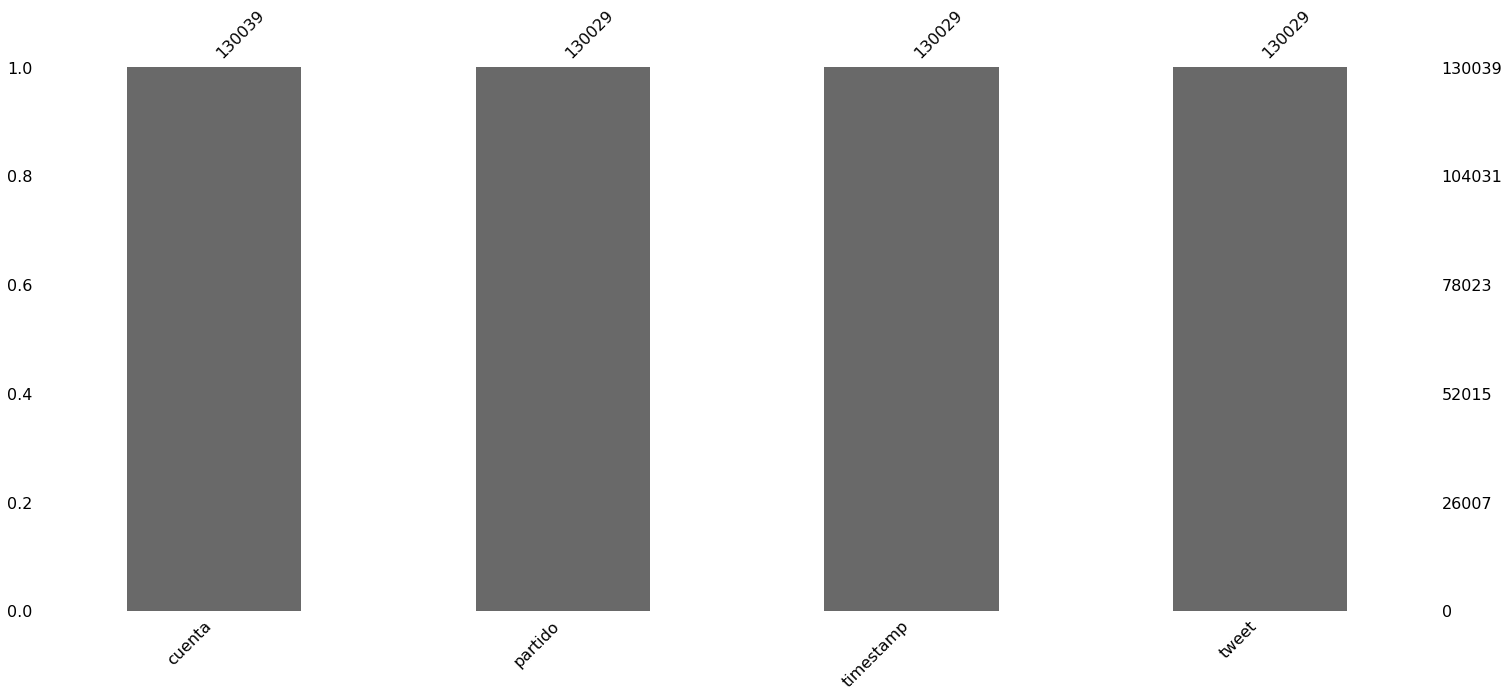

In [5]:
## Analisis de valores nulos
p = msno.bar(df)

In [6]:
#Eliminacion de filas con valores nulos
df_clean= df.dropna()
df_clean

,cuenta,partido,timestamp,tweet
0,a34133350b0605cb24081843f63176ca,psoe,1.363973e+09,@vesteve3 @manubenas @ccoo_rm @desobediencia_ ...
1,a34133350b0605cb24081843f63176ca,psoe,1.364061e+09,"“@kirovast: @Hugo_Moran muy fan de la ""radical..."
2,a34133350b0605cb24081843f63176ca,psoe,1.364117e+09,@ALTAS_PRESIONES Nuevos dueños para las renova...
3,a34133350b0605cb24081843f63176ca,psoe,1.364121e+09,@jumanjisolar @solartradex @josea_dolera El di...
4,a34133350b0605cb24081843f63176ca,psoe,1.364153e+09,“@cesarnayu: https://t.co/J4OTXj1x7w … Por fav...
...,...,...,...,...
130024,2a5fcd1034beb5bd30bf5a1528008d81,psoe,1.633250e+09,"Qué maravilla, visitar #LaRioja en #vendimia🍇,..."
130025,1e826d8471835f7feb02f8028b736ebb,pp,1.633250e+09,"“Querido Pablo, nos complace tu voluntad de re..."
130026,aeaa6ce266f823338e7d2222032a9edd,psoe,1.633250e+09,"Quiero reivindicar la buena política, la de fr..."
130027,aeaa6ce266f823338e7d2222032a9edd,psoe,1.633250e+09,🙋🏻‍♀️El pasado viernes se cumplió el aniversar...


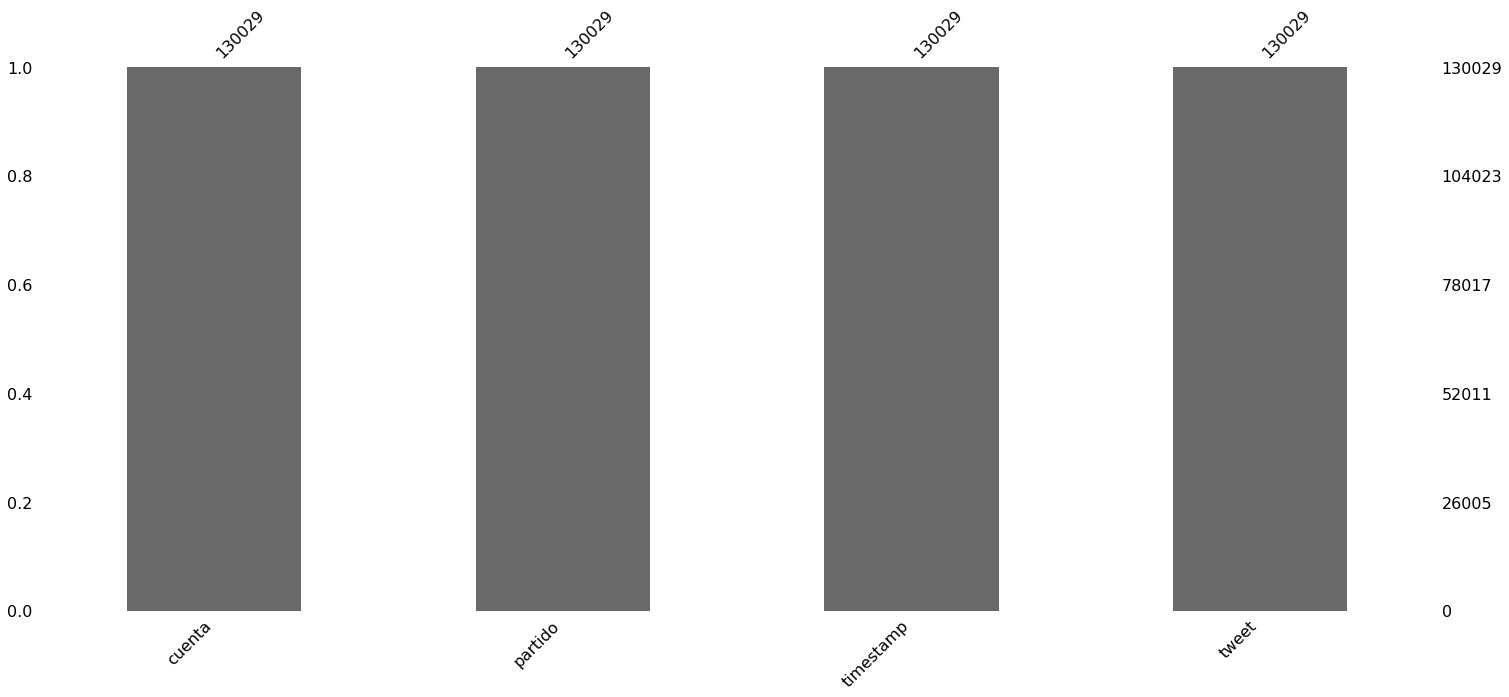

In [7]:
p = msno.bar(df_clean)

### Eliminacion de filas repetidas

In [8]:
#Verificar filas duplicadas
y=0
for i in df_clean.duplicated():
    if i==True:
        y+=1
print("Hay",y, "datos repetidos.")
    

Hay 374 datos repetidos.


In [9]:
#Limpieza de valores duplicados
df_final=df_clean.drop_duplicates() 

### Eliminacion de Valores Atipicos

In [10]:
def pocos(a):
    z = []
    for i,y in a.iterrows():
        if len(y['tweet']) < 4:
            z.append(i)
    return z

In [11]:
lis = pocos(df_final)
lis

[30414, 45203, 104996, 118383]

In [12]:
df_final=df_final.drop(index=lis)

## Analisis de los datos limpios

In [13]:
df_final

,cuenta,partido,timestamp,tweet
0,a34133350b0605cb24081843f63176ca,psoe,1.363973e+09,@vesteve3 @manubenas @ccoo_rm @desobediencia_ ...
1,a34133350b0605cb24081843f63176ca,psoe,1.364061e+09,"“@kirovast: @Hugo_Moran muy fan de la ""radical..."
2,a34133350b0605cb24081843f63176ca,psoe,1.364117e+09,@ALTAS_PRESIONES Nuevos dueños para las renova...
3,a34133350b0605cb24081843f63176ca,psoe,1.364121e+09,@jumanjisolar @solartradex @josea_dolera El di...
4,a34133350b0605cb24081843f63176ca,psoe,1.364153e+09,“@cesarnayu: https://t.co/J4OTXj1x7w … Por fav...
...,...,...,...,...
130024,2a5fcd1034beb5bd30bf5a1528008d81,psoe,1.633250e+09,"Qué maravilla, visitar #LaRioja en #vendimia🍇,..."
130025,1e826d8471835f7feb02f8028b736ebb,pp,1.633250e+09,"“Querido Pablo, nos complace tu voluntad de re..."
130026,aeaa6ce266f823338e7d2222032a9edd,psoe,1.633250e+09,"Quiero reivindicar la buena política, la de fr..."
130027,aeaa6ce266f823338e7d2222032a9edd,psoe,1.633250e+09,🙋🏻‍♀️El pasado viernes se cumplió el aniversar...


In [14]:
#Info
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129651 entries, 0 to 130028
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   cuenta     129651 non-null  object 
 1   partido    129651 non-null  object 
 2   timestamp  129651 non-null  float64
 3   tweet      129651 non-null  object 
dtypes: float64(1), object(3)
memory usage: 4.9+ MB


In [15]:
#Conteo de tweets por partido
tweet_by_class = df_final.groupby("partido", as_index=False)['tweet'].count()
tweet_by_class

,partido,tweet
0,ciudadanos,23454
1,podemos,24790
2,pp,26119
3,psoe,28786
4,vox,26502


C:\Users\edgui\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


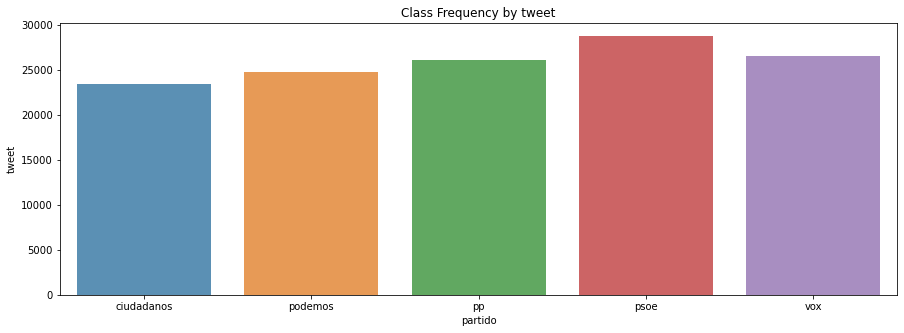

In [16]:
#Frecuencia de clases
plt.figure(figsize=(15,5))
sns.barplot(tweet_by_class['partido'].values, tweet_by_class['tweet'].values, alpha=0.8)
plt.title('Class Frequency by tweet')
plt.ylabel('tweet', fontsize=10)
plt.xlabel('partido', fontsize=10)
plt.show()

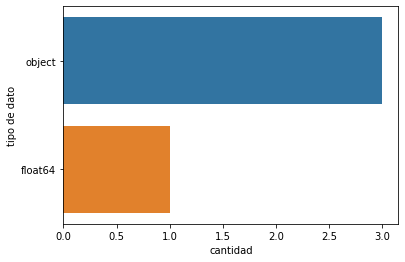

In [17]:
## distribución y balance en el tipo de datos
df_scrubbed = df_final.copy(deep = True)
sns.countplot(y=df_scrubbed.dtypes.map(str))
plt.xlabel("cantidad")
plt.ylabel("tipo de dato")
plt.show()

### Aplicacion de Label Encoding para la variable objetivo

* 0 - Ciudadanos
* 1 - Podemos
* 2 - PP
* 3 - Psoe
* 4 - Vox

In [18]:
#Label enconding para variable objetivo
my_label = preprocessing.LabelEncoder()   
df_final['partido']=my_label.fit_transform(df_final['partido'])   
df_final

,cuenta,partido,timestamp,tweet
0,a34133350b0605cb24081843f63176ca,3,1.363973e+09,@vesteve3 @manubenas @ccoo_rm @desobediencia_ ...
1,a34133350b0605cb24081843f63176ca,3,1.364061e+09,"“@kirovast: @Hugo_Moran muy fan de la ""radical..."
2,a34133350b0605cb24081843f63176ca,3,1.364117e+09,@ALTAS_PRESIONES Nuevos dueños para las renova...
3,a34133350b0605cb24081843f63176ca,3,1.364121e+09,@jumanjisolar @solartradex @josea_dolera El di...
4,a34133350b0605cb24081843f63176ca,3,1.364153e+09,“@cesarnayu: https://t.co/J4OTXj1x7w … Por fav...
...,...,...,...,...
130024,2a5fcd1034beb5bd30bf5a1528008d81,3,1.633250e+09,"Qué maravilla, visitar #LaRioja en #vendimia🍇,..."
130025,1e826d8471835f7feb02f8028b736ebb,2,1.633250e+09,"“Querido Pablo, nos complace tu voluntad de re..."
130026,aeaa6ce266f823338e7d2222032a9edd,3,1.633250e+09,"Quiero reivindicar la buena política, la de fr..."
130027,aeaa6ce266f823338e7d2222032a9edd,3,1.633250e+09,🙋🏻‍♀️El pasado viernes se cumplió el aniversar...


# Separacion del dataframe en train  y test 

In [19]:
test = pd.DataFrame()
train = df_final
size = round(round(df_final.shape[0]*0.2)/5)
for typ in list(df_final['partido'].dropna().unique()):
    samples = df_final[df_final['partido'] == typ].sample(size)
    test = test.append(samples)
    train = train.drop(samples.index)
test = test.reset_index()
train = train.reset_index()

## Dataframe de test

In [20]:
test

,index,cuenta,partido,timestamp,tweet
0,13158,aeaa6ce266f823338e7d2222032a9edd,3,1.564036e+09,📺@carmencalvo_ en @EspejoPublico: Siempre hemo...
1,29754,aeaa6ce266f823338e7d2222032a9edd,3,1.572524e+09,🗣️ @NadiaCalvino en @DebatAlRojoVivo: Tenemos ...
2,54260,b01d435b24a17890fb701cef5253cc06,3,1.582285e+09,Intensa actividad de reuniones en Bruselas en ...
3,99718,aeaa6ce266f823338e7d2222032a9edd,3,1.620375e+09,Es ineludible la transformación del modelo pro...
4,101686,fdce0be92377e5874e04584c4eac7461,3,1.621235e+09,Dos millones y medio largo de vacunas en una s...
...,...,...,...,...,...
25925,16738,8fbbab0ad3015a97ca31cefec4bba92a,1,1.567143e+09,Todo mi apoyo a los compañeros y compañeras en...
25926,113315,4102f38acd405df5e9c62e37a81e21fd,1,1.625993e+09,Mis condolencias a familiares y personas cerca...
25927,11903,826c875d34abcc10338dfe7f9db7ac3e,1,1.563388e+09,1. Mucho hablar de democratizar la UE pero @vo...
25928,69946,1d2650bd15db33115502411d5790c9df,1,1.607070e+09,El derecho a la vivienda no puede ser un privi...


C:\Users\edgui\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


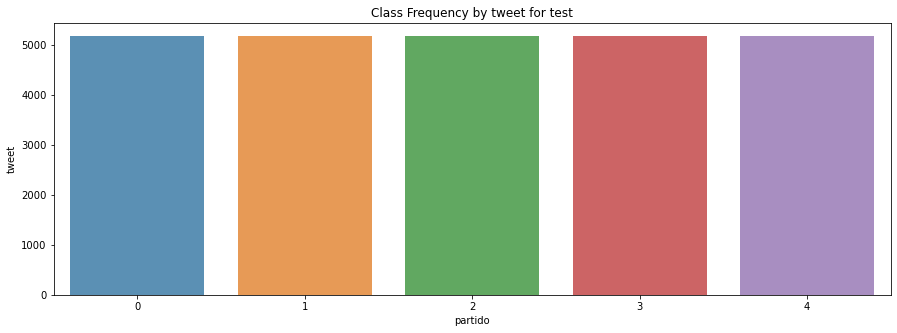

In [21]:
tweet_by_class_test = test.groupby("partido", as_index=False)['tweet'].count()

plt.figure(figsize=(15,5))
sns.barplot(tweet_by_class_test['partido'].values, tweet_by_class_test['tweet'].values, alpha=0.8)
plt.title('Class Frequency by tweet for test')
plt.ylabel('tweet', fontsize=10)
plt.xlabel('partido', fontsize=10)
plt.show()

## Dataframe de train

In [24]:
train

,index,cuenta,partido,timestamp,tweet
0,0,a34133350b0605cb24081843f63176ca,3,1.363973e+09,@vesteve3 @manubenas @ccoo_rm @desobediencia_ ...
1,1,a34133350b0605cb24081843f63176ca,3,1.364061e+09,"“@kirovast: @Hugo_Moran muy fan de la ""radical..."
2,2,a34133350b0605cb24081843f63176ca,3,1.364117e+09,@ALTAS_PRESIONES Nuevos dueños para las renova...
3,3,a34133350b0605cb24081843f63176ca,3,1.364121e+09,@jumanjisolar @solartradex @josea_dolera El di...
4,4,a34133350b0605cb24081843f63176ca,3,1.364153e+09,“@cesarnayu: https://t.co/J4OTXj1x7w … Por fav...
...,...,...,...,...,...
103716,130022,aeaa6ce266f823338e7d2222032a9edd,3,1.633250e+09,"El Presidente del Gobierno, @sanchezcastejon, ..."
103717,130024,2a5fcd1034beb5bd30bf5a1528008d81,3,1.633250e+09,"Qué maravilla, visitar #LaRioja en #vendimia🍇,..."
103718,130026,aeaa6ce266f823338e7d2222032a9edd,3,1.633250e+09,"Quiero reivindicar la buena política, la de fr..."
103719,130027,aeaa6ce266f823338e7d2222032a9edd,3,1.633250e+09,🙋🏻‍♀️El pasado viernes se cumplió el aniversar...


C:\Users\edgui\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


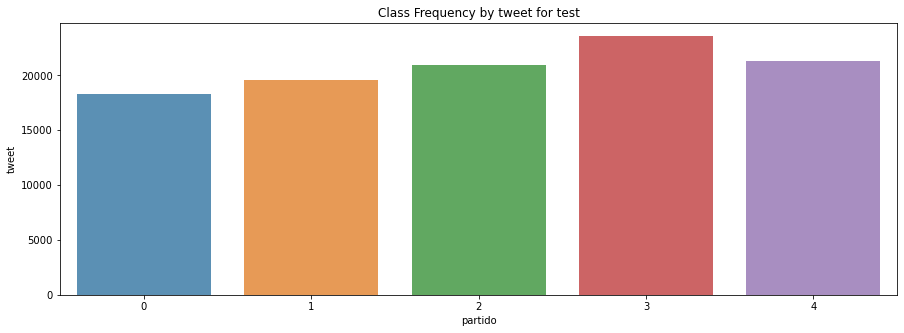

In [25]:
tweet_by_class_test = train.groupby("partido", as_index=False)['tweet'].count()

plt.figure(figsize=(15,5))
sns.barplot(tweet_by_class_test['partido'].values, tweet_by_class_test['tweet'].values, alpha=0.8)
plt.title('Class Frequency by tweet for test')
plt.ylabel('tweet', fontsize=10)
plt.xlabel('partido', fontsize=10)
plt.show()

# Tratamiento de Datos

### Limpieza de tweets

In [26]:
#Limpieza de tweets de entrenamiento
x_train = [tp.transformer(row) for row in train['tweet'].tolist()]
y_train = train["partido"]
len(x_train), len(y_train)

(103721, 103721)

In [27]:
#Limpieza de tweets de prueba
x_test = [tp.transformer(row) for row in test['tweet'].tolist()]
y_test = test["partido"]
len(x_test), len(y_test)

(25930, 25930)

#### Eliminacion de filas vacias

In [28]:
y = 0
for i in x_train:
    if len(i) < 1:
        del x_train[y]
        del y_train[y]
    y+=1

In [29]:
len(x_train), len(y_train)

(103719, 103719)

## Técnicas de extracción de características

In [30]:
#TF-IDF
tfIdfVectorizer=TfidfVectorizer(ngram_range=(3,3), min_df=100, max_df = 0.85, max_features=10000)

#Bow of n-gram
bow = CountVectorizer(analyzer='word', ngram_range=(3, 3), min_df=100, max_df = 0.85, max_features=10000)

### Union de caracteristicas

In [31]:
preprocessor = FeatureUnion([
    ('tfidf_vector', tfIdfVectorizer),
    ('bow', bow)
])

preprocessor.fit(x_train)

FeatureUnion(transformer_list=[('tfidf_vector',
                                TfidfVectorizer(max_df=0.85, max_features=10000,
                                                min_df=100,
                                                ngram_range=(3, 3))),
                               ('bow',
                                CountVectorizer(max_df=0.85, max_features=10000,
                                                min_df=100,
                                                ngram_range=(3, 3)))])

### Extraccion de caracteristicas

In [32]:
x_train = preprocessor.transform(x_train)
x_test = preprocessor.transform(x_test)

In [33]:
print('**Sample train:', sorted(Counter(y_train).items()))
print('**Sample test:', sorted(Counter(y_test).items()))

**Sample train: [(0, 18268), (1, 19604), (2, 20933), (3, 23598), (4, 21316)]
**Sample test: [(0, 5186), (1, 5186), (2, 5186), (3, 5186), (4, 5186)]


# Modelos de clasificacion

### Modelo SVM

In [34]:
svc = svm.SVC(kernel='linear', C=1, max_iter=10000)

In [35]:
svc.fit(x_train,y_train)

C:\Users\edgui\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


SVC(C=1, kernel='linear', max_iter=10000)

In [36]:
svc.score(x_test, y_test)

0.30404936367142305

### Modelo Softmax

In [37]:
softmax = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10, max_iter=10000)

In [38]:
softmax.fit(x_train,y_train)

LogisticRegression(C=10, max_iter=10000, multi_class='multinomial')

In [39]:
softmax.score(x_test, y_test)

0.3760123409178558

# Validacion cruzada

In [40]:
k_fold = ShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

In [41]:
accuracies_scores = []
recalls_scores = []
precisions_scores = []
f1_scores = []

In [46]:
y_train=y_train.to_numpy()

### SVM

In [47]:
for train_index, test_index in k_fold.split(x_train, y_train):
    data_train = x_train[train_index]
    target_train = y_train[train_index]
    
    data_test = x_train[test_index]
    target_test = y_train[test_index]

    svc.fit(data_train, target_train)
    predict = svc.predict(data_test)
    # Accuracy
    accuracy = accuracy_score(target_test, predict)
    accuracies_scores.append(accuracy)
    # Recall
    recall = recall_score(target_test, predict, average='macro')
    recalls_scores.append(recall)
    # Precision
    precision = precision_score(target_test, predict, average='weighted')
    precisions_scores.append(precision)
    # F1
    f1 = f1_score(target_test, predict, average='micro')
    f1_scores.append(f1)

C:\Users\edgui\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\edgui\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\edgui\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\edgui\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

In [48]:
average_recall = round(np.mean(recalls_scores) * 100, 2)
average_precision = round(np.mean(precisions_scores) * 100, 2)
average_f1 = round(np.mean(f1_scores) * 100, 2)
average_accuracy = round(np.mean(accuracies_scores) * 100, 2)

In [50]:
y_predict = []
for features in x_test:
    features = features.reshape(1, -1)
    value = svc.predict(features)[0]
    y_predict.append(value)

classification = classification_report(y_test, y_predict)
confusion = confusion_matrix(y_predict, y_test)

In [51]:
output_result = {'F1-score': average_f1, 'Accuracy': average_accuracy, 'Recall': average_recall, 
                 'Precision': average_precision, 'Classification Report\n': classification, 
                 'Confusion Matrix\n': confusion}

In [52]:
for item, val in output_result.items():
    print('{0} {1}'.format(item, val))

F1-score 31.7
Accuracy 31.7
Recall 31.09
Precision 36.68
Classification Report
               precision    recall  f1-score   support

           0       0.36      0.14      0.21      5186
           1       0.48      0.17      0.25      5186
           2       0.39      0.19      0.25      5186
           3       0.33      0.25      0.29      5186
           4       0.26      0.79      0.39      5186

    accuracy                           0.31     25930
   macro avg       0.36      0.31      0.28     25930
weighted avg       0.36      0.31      0.28     25930

Confusion Matrix
 [[ 746  302  457  346  236]
 [ 225  874  218  354  152]
 [ 493  313  976  385  317]
 [ 725  856  685 1312  399]
 [2997 2841 2850 2789 4082]]


### Softmax

In [53]:
for train_index, test_index in k_fold.split(x_train, y_train):
    data_train = x_train[train_index]
    target_train = y_train[train_index]
    
    data_test = x_train[test_index]
    target_test = y_train[test_index]

    softmax.fit(data_train, target_train)
    predict = softmax.predict(data_test)
    # Accuracy
    accuracy = accuracy_score(target_test, predict)
    accuracies_scores.append(accuracy)
    # Recall
    recall = recall_score(target_test, predict, average='macro')
    recalls_scores.append(recall)
    # Precision
    precision = precision_score(target_test, predict, average='weighted')
    precisions_scores.append(precision)
    # F1
    f1 = f1_score(target_test, predict, average='micro')
    f1_scores.append(f1)

In [54]:
average_recall = round(np.mean(recalls_scores) * 100, 2)
average_precision = round(np.mean(precisions_scores) * 100, 2)
average_f1 = round(np.mean(f1_scores) * 100, 2)
average_accuracy = round(np.mean(accuracies_scores) * 100, 2)

In [58]:
y_predict = []
for features in x_test:
    features = features.reshape(1, -1)
    value = softmax.predict(features)[0]
    y_predict.append(value)

classification = classification_report(y_test, y_predict)
confusion = confusion_matrix(y_predict, y_test)

In [59]:
output_result = {'F1-score': average_f1, 'Accuracy': average_accuracy, 'Recall': average_recall, 
                 'Precision': average_precision, 'Classification Report\n': classification, 
                 'Confusion Matrix\n': confusion}

In [60]:
for item, val in output_result.items():
    print('{0} {1}'.format(item, val))

F1-score 34.85
Accuracy 34.85
Recall 34.32
Precision 39.32
Classification Report
               precision    recall  f1-score   support

           0       0.44      0.24      0.31      5186
           1       0.46      0.29      0.36      5186
           2       0.47      0.29      0.36      5186
           3       0.41      0.36      0.38      5186
           4       0.29      0.68      0.41      5186

    accuracy                           0.37     25930
   macro avg       0.41      0.37      0.36     25930
weighted avg       0.41      0.37      0.36     25930

Confusion Matrix
 [[1235  378  512  314  369]
 [ 456 1500  373  537  362]
 [ 604  372 1528  395  383]
 [ 690  772  668 1863  550]
 [2201 2164 2105 2077 3522]]
